# Data Preprocessing for Retail Dataset
### This notebook provides different methods for cleaning and preprocessing a retail dataset as well as finding rules with the apriori algorithm. You can choose different approaches based on your needs, such as filtering by date or maximizing the number of customers.

In [60]:
import pandas as pd

# Load dataset
df = pd.read_csv("../datasets/retail.csv")
print("Dataset Loaded.")
df.head()

Dataset Loaded.


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Handling Missing Values
### One way of handing missing values is to simply remove all the rows which contain missing values.

In [18]:
df.dropna(inplace=True)

### Since we would like to keep most of the data, we will apply some default values when the missing values are not that important, or when the entries can still be used for other feature extracting.

In [62]:
fill_na = {
    "Description": "No description available",
    "Country": "Unknown",
    "Customer ID": 0,
    "Quantity": 0,
    "InvoiceDate": df["InvoiceDate"].min()
}
df.fillna(fill_na, inplace=True)

### When the Invoice or StockCode missing, we will discard the entries either way.

In [63]:
# Remove all transactions without Invoice and StockCode since these are important info
df.dropna(subset=["Invoice"], inplace=True)
df.dropna(subset=["StockCode"], inplace=True)

### When the price is missing, we will search for products with the same StockCode and take the price of that product.

In [64]:
# Search for other products with same StockCode and copy price if found.
def fill_price(row):
    if pd.isna(row["Price"]):
        stock_price = df.loc[df["StockCode"] == row["StockCode"], "Price"].dropna().iloc[0] if not df.loc[df["StockCode"] == row["StockCode"], "Price"].dropna().empty else np.nan
        return stock_price
    return row["Price"]

df["Price"] = df.apply(fill_price, axis=1)



### When the quantity of a transaction is negative, we assume that the product is returned and thus we can remove the entries.

In [65]:
df = df.loc[df["Quantity"] > 0].copy()

## Filtering Dataset
### A function is made such that you can choose on what to filter, and have the option to choose a random interval/selection

In [41]:
import numpy as np

# Prune dataset based on column, amount and randomness. If random = False, take the first N entries.
def prune_dataset(df, column, amount, random=False):
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

    # Filter by InvoiceDate
    if column == "InvoiceDate":
        if random:
            unique_dates = df["InvoiceDate"].dt.date.unique()
            selected_dates = np.random.choice(unique_dates, min(amount, len(unique_dates)), replace=False)
            df = df[df["InvoiceDate"].dt.date.isin(selected_dates)]
        else:
            earliest_date = df["InvoiceDate"].min()
            df = df[df["InvoiceDate"] < earliest_date + pd.Timedelta(days=amount)]

    # Filter by Customer ID
    elif column == "Customer ID":
        unique_customers = df["Customer ID"].unique()
        if random:
            selected_customers = np.random.choice(unique_customers, min(amount, len(unique_customers)), replace=False)
        else:
            selected_customers = df["Customer ID"].value_counts().nsmallest(amount).index
        df = df[df["Customer ID"].isin(selected_customers)]

    # Filter by Invoice
    elif column == "Invoice":
        unique_invoices = df["Invoice"].unique()
        if random:
            selected_invoices = np.random.choice(unique_invoices, min(amount, len(unique_invoices)), replace=False)
        else:
            selected_invoices = df["Invoice"].value_counts().nsmallest(amount).index
        df = df[df["Invoice"].isin(selected_invoices)]

    return df

### You can now for example say you want the 100 last days of data.

In [61]:
df = prune_dataset(df, "InvoiceDate", 100, False)

### Or lets say say you want 30 random customers.

In [ ]:
df = prune_dataset(df, "Customer ID", 30, True)

## Feature Engineering
### We can add different categories to easily seperate products/transaction/customers that are have things in common. A logical category for a retail dataset is by differentiating all transactions based on there time of purchase in the day. We can split in Morning, Afternoon, Evening and Night. Additionally, we can add a category for each day of the week.

In [66]:
# Return moment of day based on hour
def categorize_time(hour):
    if 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    elif 18 <= hour < 24:
        return "Evening"
    else:
        return "Night"

# Convert InvoiceDate to datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df["TimeOfDay"] = df["InvoiceDate"].dt.hour.apply(categorize_time)

# Add category for day of week, placing "Monday", "Tuesday", ...
df["DayOfWeek"] = df["InvoiceDate"].dt.day_name()

### For the categorization of the price and quantity of transactions, we can use pandas qcut to evenly distribute the entries.

In [67]:
# For splitting up the price category, only look at the prices of the unique products, eliminating the case where 1 product is bought multiple times and overrules other products.
unique_prices = df.drop_duplicates(subset="StockCode")["Price"]
price_bins, price_edges = pd.qcut(unique_prices, q=3, labels=["Cheap", "Mid-Range", "Expensive"], duplicates="drop", retbins=True)

# Split up prices in "Cheap', "Mid-range" and "Expensive
df["PriceCategory"] = pd.cut(df["Price"], bins=price_edges, labels=["Cheap", "Mid-Range", "Expensive"], include_lowest=True)
print(price_edges)

# Split up quantities in "Small', "Medium" and "Large"
df["QuantityCategory"], quantity_edges = pd.qcut(df["Quantity"], q=3, labels=["Small", "Medium", "Large"], duplicates="drop", retbins=True)
print(quantity_edges)

[  0.     1.65   3.9  647.19]
[1.0000e+00 2.0000e+00 6.0000e+00 1.9152e+04]


### We can create some plots to show the distribution of the entries and get a better view of the data.

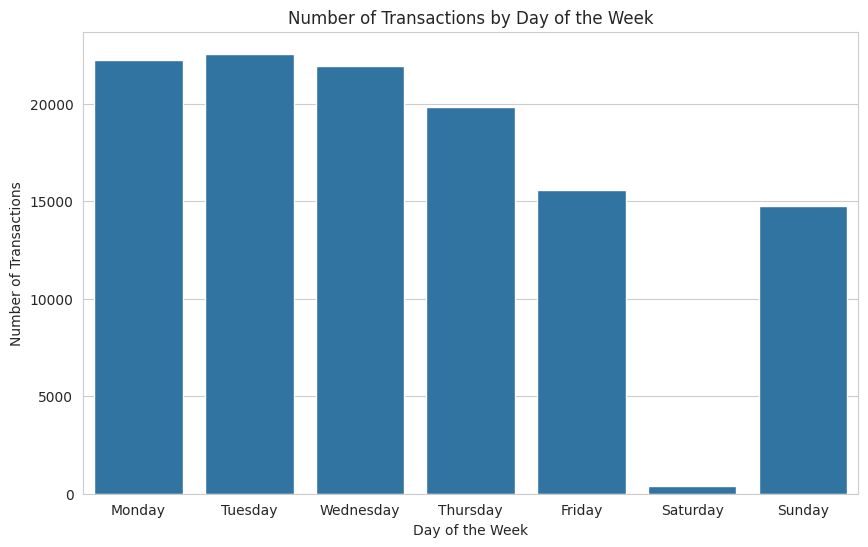

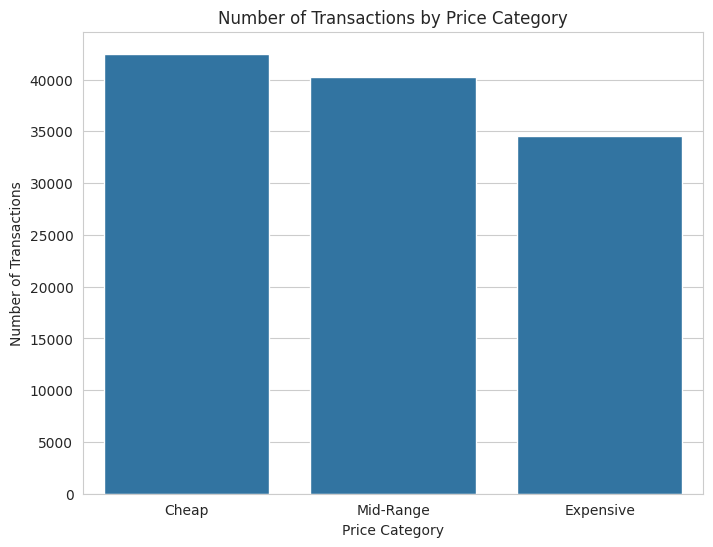

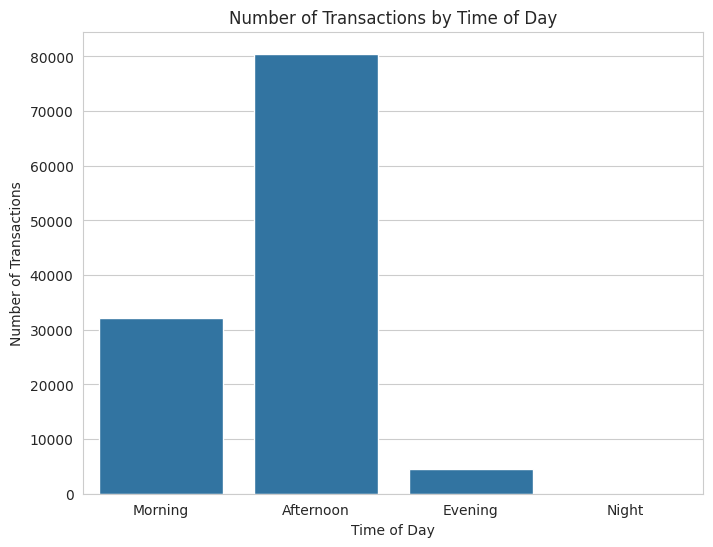

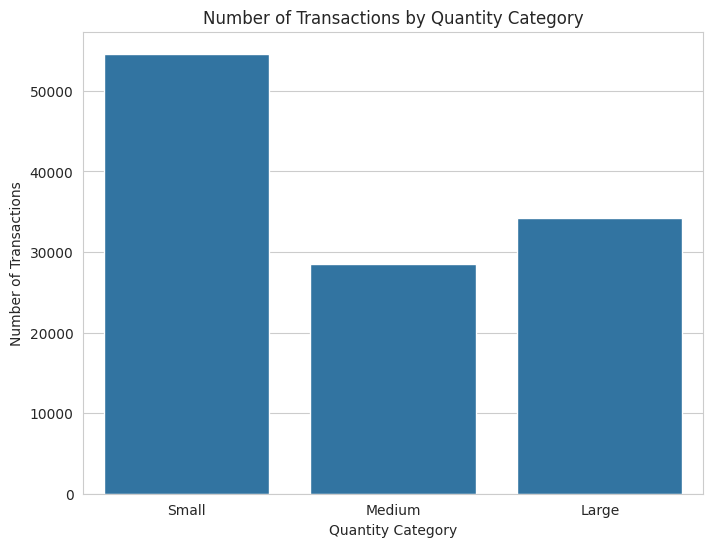

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x="DayOfWeek", data=df, order=[
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])
plt.title("Number of Transactions by Day of the Week")
plt.ylabel("Number of Transactions")
plt.xlabel("Day of the Week")
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x="PriceCategory", data=df)
plt.title("Number of Transactions by Price Category")
plt.ylabel("Number of Transactions")
plt.xlabel("Price Category")
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x="TimeOfDay", data=df, order=["Morning", "Afternoon", "Evening", "Night"])
plt.title("Number of Transactions by Time of Day")
plt.ylabel("Number of Transactions")
plt.xlabel("Time of Day")
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x="QuantityCategory", data=df)
plt.title("Number of Transactions by Quantity Category")
plt.ylabel("Number of Transactions")
plt.xlabel("Quantity Category")
plt.show()

## Mining Association Rules
### Before mining the rules in the dataset, I created a function that prints out the best rules in a clean format, showing the Support, Confidence and Lift, as well as the description if mining was done on stockcodes.

In [174]:
def display_association_rules(rules, mapping=None, top_n=100):
    # Function to convert StockCode to Description
    def map_item(item):
        if mapping is not None:
            return mapping.get(item, item)
        return item

    # Sort rules by highest confidence (considering the maximum confidence among ordered_statistics)
    sorted_rules = sorted(
        rules,
        key=lambda rule: max(stat.confidence for stat in rule.ordered_statistics),
        reverse=True
    )
    top_n = min(top_n, len(sorted_rules))

    # Print product association rules with descriptions
    print("\n--- ASSOCIATION RULES (Sorted by Confidence) ---\n")
    for rule in sorted_rules[:top_n]:
        # Convert StockCodes to Descriptions
        items = [map_item(x) for x in rule.items]
        print(f"Rule: {items} | Support: {rule.support:.4f}")
        for ordered_stat in rule.ordered_statistics:
            base = ', '.join(map_item(x) for x in ordered_stat.items_base)
            add = ', '.join(map_item(x) for x in ordered_stat.items_add)
            print(f"  {base} -> {add} | Confidence: {ordered_stat.confidence:.4f} | Lift: {ordered_stat.lift:.4f}")
        print("-" * 50)

    # Prepare data for scatter plot using the same top_n rules.
    rules_list = []
    for rule in sorted_rules[:top_n]:
        for ordered_stat in rule.ordered_statistics:
            base = ', '.join(map_item(x) for x in ordered_stat.items_base)
            add = ', '.join(map_item(x) for x in ordered_stat.items_add)
            rule_str = f""
            rules_list.append({
                'rule': rule_str,
                'support': rule.support,
                'confidence': ordered_stat.confidence,
                'lift': ordered_stat.lift
            })

    rules_df = pd.DataFrame(rules_list)

    if rules_df.empty:
        print("No rules extracted to plot.")
        return

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    # Scale marker sizes based on lift (adjust factor as needed)
    sizes = rules_df['lift'] * 10
    scatter = plt.scatter(rules_df['support'], rules_df['confidence'],
                          s=sizes, c=rules_df['lift'], cmap='viridis', alpha=0.7)

    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.title(f'Scatter Plot of Association Rules')

    # Add a colorbar to show lift values
    cbar = plt.colorbar(scatter)
    cbar.set_label('Lift')

    # Annotate each point with the rule text
    for i, row in rules_df.iterrows():
        plt.annotate(row['rule'], (row['support'], row['confidence']),
                     fontsize=8, alpha=0.8, textcoords="offset points", xytext=(5,5))

    plt.show()


### The most common case of pattern mining is to group the transactions where the invoice is the same, and get rules between different products.



--- ASSOCIATION RULES (Sorted by Confidence) ---

Rule: ['PINK FELT EASTER EGG BASKET', 'BLUE FELT EASTER EGG BASKET'] | Support: 0.0168
  BLUE FELT EASTER EGG BASKET -> PINK FELT EASTER EGG BASKET | Confidence: 0.8737 | Lift: 35.1818
  PINK FELT EASTER EGG BASKET -> BLUE FELT EASTER EGG BASKET | Confidence: 0.6748 | Lift: 35.1818
--------------------------------------------------
Rule: ['SET/10 PINK SPOTTY PARTY CANDLES', 'SET/10 BLUE SPOTTY PARTY CANDLES'] | Support: 0.0176
  SET/10 PINK SPOTTY PARTY CANDLES -> SET/10 BLUE SPOTTY PARTY CANDLES | Confidence: 0.6850 | Lift: 32.9417
  SET/10 BLUE SPOTTY PARTY CANDLES -> SET/10 PINK SPOTTY PARTY CANDLES | Confidence: 0.8447 | Lift: 32.9417
--------------------------------------------------
Rule: ['RED HANGING HEART T-LIGHT HOLDER', 'WHITE HANGING HEART T-LIGHT HOLDER'] | Support: 0.0507
  RED HANGING HEART T-LIGHT HOLDER -> WHITE HANGING HEART T-LIGHT HOLDER | Confidence: 0.7994 | Lift: 4.6145
-------------------------------------------

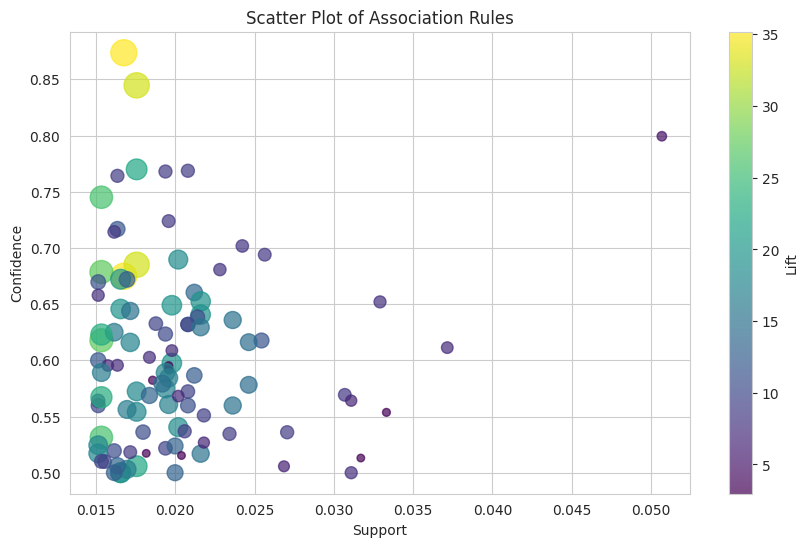

In [175]:
from apyori import apriori

# Used for mapping StockCodes to Descriptions
stockcode_to_description = df.set_index("StockCode")["Description"].to_dict()

product_transactions = df.groupby("Invoice")["StockCode"].apply(list).tolist()

# Run Apriori for Product-Product category association
product_rules = list(apriori(
    product_transactions,
    min_support=0.015,
    min_confidence=0.5,
    min_lift=1.1,
    min_length=2
))

display_association_rules(product_rules, stockcode_to_description)

### Now we can check if some products are more likely to get bought at certain times in the day:

/tmp/ipykernel_20121/3726890584.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_transactions = df.groupby("Invoice").apply(



--- ASSOCIATION RULES (Sorted by Confidence) ---

Rule: ['Afternoon', 'VINTAGE UNION JACK BUNTING'] | Support: 0.0256
  VINTAGE UNION JACK BUNTING -> Afternoon | Confidence: 0.7840 | Lift: 1.1871
--------------------------------------------------
Rule: ['HAND OVER THE CHOCOLATE   SIGN ', 'Afternoon'] | Support: 0.0275
  HAND OVER THE CHOCOLATE   SIGN  -> Afternoon | Confidence: 0.7771 | Lift: 1.1768
--------------------------------------------------
Rule: ['Afternoon', 'FELTCRAFT BUTTERFLY HEARTS'] | Support: 0.0293
  FELTCRAFT BUTTERFLY HEARTS -> Afternoon | Confidence: 0.7632 | Lift: 1.1556
--------------------------------------------------
Rule: ['Afternoon', 'RED HANGING HEART T-LIGHT HOLDER', 'WHITE HANGING HEART T-LIGHT HOLDER'] | Support: 0.0325
  RED HANGING HEART T-LIGHT HOLDER -> Afternoon, WHITE HANGING HEART T-LIGHT HOLDER | Confidence: 0.5127 | Lift: 4.4790
  Afternoon, RED HANGING HEART T-LIGHT HOLDER -> WHITE HANGING HEART T-LIGHT HOLDER | Confidence: 0.7630 | Lift: 4.4

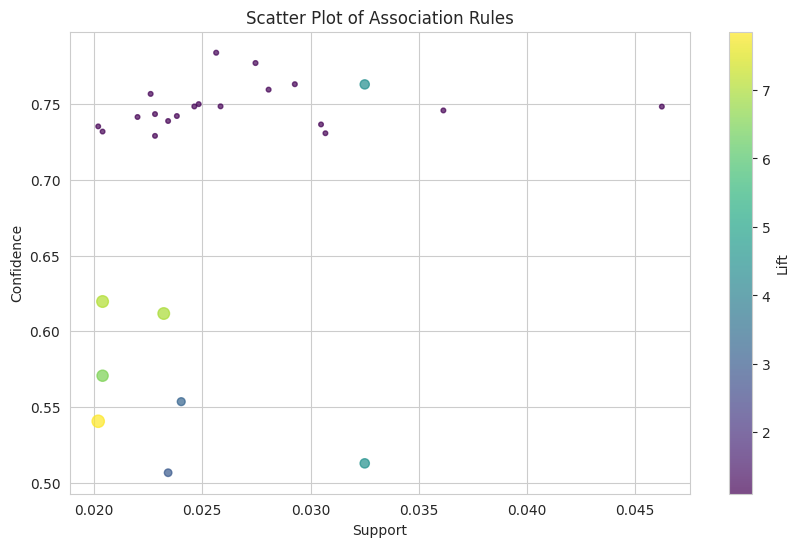

In [177]:
combined_transactions = df.groupby("Invoice").apply(
    lambda x: x.drop(columns="Invoice")["StockCode"].tolist() + [x["TimeOfDay"].iloc[0]]
).tolist()

# Run Apriori for Product-TimeOfDay category association
timing_rules = list(apriori(
    combined_transactions,
    min_support=0.02,
    min_confidence=0.5,
    min_lift=1.1,
    min_length=2
))

# Filter out rules containing multiple time categories
filtered_timing_rules = []
for rule in timing_rules:
    items = list(rule.items)

    # Ensure TimeCategory is not repeated
    time_categories = [item for item in items if item in ["Morning", "Afternoon", "Evening", "Night"]]

    if len(time_categories) == 1:  # Only allow one time-related element
        filtered_timing_rules.append(rule)

display_association_rules(filtered_timing_rules, stockcode_to_description)


### Instead of looking at the products, we can also look at customers and check if there are any associations with the price of the products they bought.


--- ASSOCIATION RULES (Sorted by Confidence) ---

Rule: ['17589.0', 'Cheap'] | Support: 0.0010
  17589.0 -> Cheap | Confidence: 0.7724 | Lift: 2.1316
--------------------------------------------------
Rule: ['13542.0', 'Expensive'] | Support: 0.0005
  13542.0 -> Expensive | Confidence: 0.7564 | Lift: 2.5695
--------------------------------------------------
Rule: ['14286.0', 'Cheap'] | Support: 0.0009
  14286.0 -> Cheap | Confidence: 0.7537 | Lift: 2.0801
--------------------------------------------------
Rule: ['Cheap', '14298.0'] | Support: 0.0013
  14298.0 -> Cheap | Confidence: 0.7381 | Lift: 2.0369
--------------------------------------------------
Rule: ['Cheap', '15013.0'] | Support: 0.0007
  15013.0 -> Cheap | Confidence: 0.7304 | Lift: 2.0158
--------------------------------------------------
Rule: ['Cheap', '13694.0'] | Support: 0.0029
  13694.0 -> Cheap | Confidence: 0.7296 | Lift: 2.0135
--------------------------------------------------
Rule: ['Cheap', '12867.0'] | Suppor

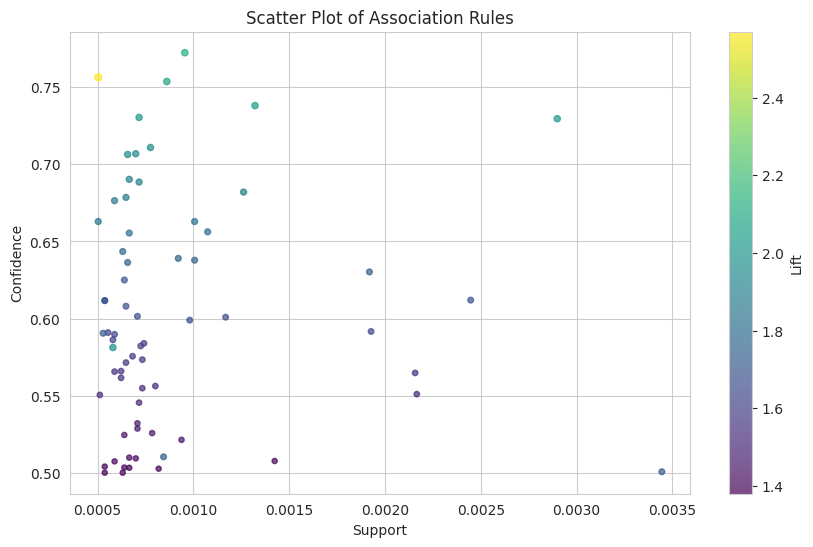

In [178]:
combined_transactions = df.dropna(subset=["Customer ID", "PriceCategory"]).apply(
    lambda x: [str(x["Customer ID"]), x["PriceCategory"]], axis=1
).tolist()

# Run Apriori for customer-price category association
customer_rules = list(apriori(
    combined_transactions,
    min_support=0.0005,
    min_confidence=0.5,
    min_lift=1.1,
    min_length=2
))

# Filter out rules between price categories only (keep customer-price links)
filtered_customer_rules = []
for rule in customer_rules:
    items = list(rule.items)

    # Ensure only one price category is present in each rule
    price_categories = [item for item in items if item in ["Cheap", "Mid-Range", "Expensive"]]

    if len(price_categories) == 1:
        filtered_customer_rules.append(rule)

display_association_rules(filtered_customer_rules)


### Lastly, we can check if a high price relates to a low quantity and a low price indicates a high quantity (or ofcourse in the other way).


--- ASSOCIATION RULES (Sorted by Confidence) ---

Rule: ['Expensive', 'Small'] | Support: 0.2017
  Expensive -> Small | Confidence: 0.6851 | Lift: 1.4717
  Small -> Expensive | Confidence: 0.4332 | Lift: 1.4717
--------------------------------------------------
Rule: ['Cheap', 'Large'] | Support: 0.1969
  Cheap -> Large | Confidence: 0.5434 | Lift: 1.8632
  Large -> Cheap | Confidence: 0.6752 | Lift: 1.8632
--------------------------------------------------
Rule: ['Medium', 'Mid-Range'] | Support: 0.1080
  Medium -> Mid-Range | Confidence: 0.4447 | Lift: 1.2954
  Mid-Range -> Medium | Confidence: 0.3145 | Lift: 1.2954
--------------------------------------------------


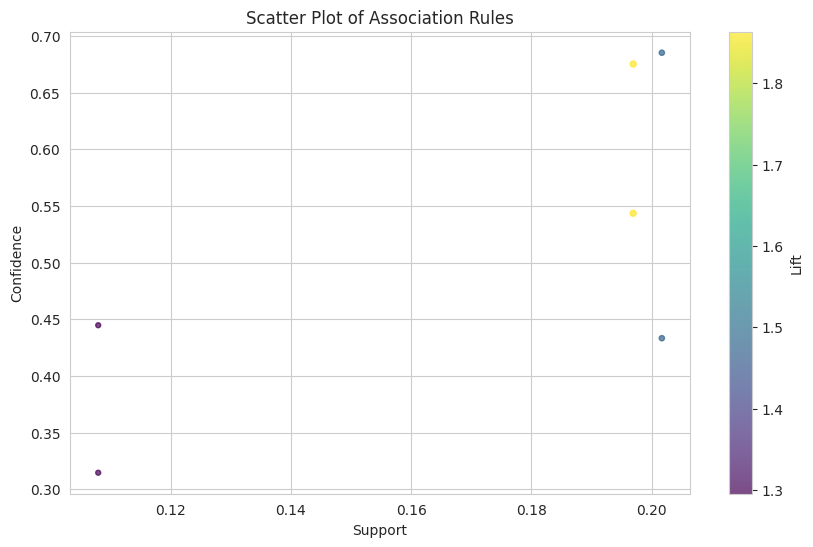

In [179]:
combined_transactions = df.dropna(subset=["QuantityCategory","PriceCategory"]).apply(
    lambda x: [x["QuantityCategory"], x["PriceCategory"]], axis=1
).tolist()

# Run Apriori for price-quantity category association
price_quantity_rules = list(apriori(
    combined_transactions,
    min_support=0.02,
    min_confidence=0.3,
    min_lift=1.1,
    min_length=2
))

# Filter out rules between price categories only (keep customer-price links)
filtered_price_quantity_rules = []
for rule in price_quantity_rules:
    items = list(rule.items)

    # Ensure only one price category is present in each rule
    price_categories = [item for item in items if item in ["Cheap", "Mid-Range", "Expensive"]]

    if len(price_categories) == 1:
        filtered_price_quantity_rules.append(rule)

display_association_rules(filtered_price_quantity_rules)
